# Combining Sentiment Analysis and Topic Modeling

In [1]:
from gensim import corpora, models, similarities
import time
import os
import random
import numpy as np
import pyLDAvis.gensim
import csv
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings('ignore')

# Ugly hackery, but necessary: stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.append('../../')

from src.streaming import spark_functions

preprocess = spark_functions.preprocessor()
# For LDA, we remove stopwords
lda_tokenize = spark_functions.tokenizer(remove_stopwords=True)
# for sentiment analysis, we don't
sa_tokenize = spark_functions.tokenizer(remove_stopwords=False)

In [2]:
# Load Data
with open('./../../data/interim/stream_en.csv') as csv_file:
    iterator = csv.reader(csv_file, delimiter=',')
    # Load the tweets we need and preprocess as well as tokenize the text
    tweets = [text for (_1, _2, _3, text) in iterator]
    preprocessed = [preprocess(text) for text in tweets]
    tokens_lda = [lda_tokenize(tweet) for tweet in preprocessed]
    tokens_sa = [sa_tokenize(tweet) for tweet in preprocessed]

In [3]:
# Load LDA model
lda_filename = './../../models/lda/gensim/tweets_stream.lda'
dict_filename = './../../data/processed/tweets_stream.dict'
dictionary = corpora.Dictionary.load(dict_filename)
lda = models.LdaModel.load(lda_filename)

In [4]:
# Load sentiment model
sa_filename = "./../../models/naive_bayes/nltk_naive_bayes.pickle"
classifier_f = open(sa_filename,"rb")
classifier = pickle.load(classifier_f)

In [5]:
# Some utility functions we need

def extract_features(document):
    document_words = set(document)
    features = {}
    # TODO do on dictionary without stopwords removed (results are the same though, see the sentiment analyzer notebook)
    for word in dictionary.token2id:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [6]:
topics_sentiments = defaultdict(lambda: {
    "positive":0,
    "neutral":0,
    "negative":0,
    "irrelevant":0
})
# For each tweet
total_time = 0
for index in range(len(tweets[:100])):
    if index % 1000 == 0:
        print("%d/%d" % (index, len(tweets)))
    # get the topics
    doc_bow = [dictionary.doc2bow(tokens_lda[index])]
    topics = lda[doc_bow][0]
    # get the sentiment
    features = extract_features(tokens_sa[index])
    t0 = time.time()
    sentiment = classifier.classify(features)
    total_time += (time.time() - t0)

    # For each topic
    for (topicid, topic_probability) in topics:
        # Add to the sentiment, weighted by the probability
        topics_sentiments[topicid][sentiment] += topic_probability

print(total_time)

0/6424
2.2550342082977295


In [7]:
# Print for LaTex table
for index in topics_sentiments:
    topic_sentiments = topics_sentiments[index]
    
    total = topic_sentiments["positive"] + topic_sentiments["negative"] + topic_sentiments["neutral"] + topic_sentiments["irrelevant"]
    
    arguments = (index,
            ", ".join(dictionary[term[0]] for term in lda.get_topic_terms(topicid=index, topn=5)),
            topic_sentiments["positive"], topic_sentiments["positive"]/total*100,
            topic_sentiments["neutral"], topic_sentiments["neutral"]/total*100,
            topic_sentiments["negative"], topic_sentiments["negative"]/total*100,
            topic_sentiments["irrelevant"], topic_sentiments["irrelevant"]/total*100,
            total, total/len(tweets)*100)
    
    
    print("%d & %s & %0.02f & %0.02f\\%% & %0.02f & %0.02f\\%% & %0.02f & %0.02f\\%% & %0.02f & %0.02f\\%% & %0.02f & %0.02f\\%% \\\\\\midrule" % arguments) 

0 & damn, remember, give, feel, ever & 1.77 & 18.59\% & 4.87 & 51.16\% & 1.61 & 16.86\% & 1.28 & 13.40\% & 9.53 & 0.15\% \\\midrule
1 & mtvhottest, lady, gaga, zara, larsson & 1.31 & 14.40\% & 4.55 & 50.04\% & 1.27 & 13.99\% & 1.96 & 21.57\% & 9.10 & 0.14\% \\\midrule
2 & time, friends, music, heart, birthday & 0.49 & 4.26\% & 5.21 & 44.97\% & 2.44 & 21.09\% & 3.44 & 29.68\% & 11.58 & 0.18\% \\\midrule
3 & wanna, sure, bring, help, wannaone & 1.21 & 13.36\% & 4.74 & 52.36\% & 0.09 & 0.97\% & 3.02 & 33.31\% & 9.05 & 0.14\% \\\midrule
4 & hate, video, buy, bts, playlist & 1.84 & 20.52\% & 3.79 & 42.19\% & 0.43 & 4.79\% & 2.92 & 32.50\% & 8.98 & 0.14\% \\\midrule
5 & tell, miss, outfit, feel, made & 1.37 & 16.95\% & 5.11 & 63.04\% & 0.43 & 5.26\% & 1.19 & 14.75\% & 8.10 & 0.13\% \\\midrule
6 & every, morning, read, still, health & 1.10 & 11.20\% & 4.37 & 44.53\% & 0.90 & 9.19\% & 3.44 & 35.08\% & 9.81 & 0.15\% \\\midrule
7 & already, take, someone, need, care & 0.17 & 2.02\% & 5.36 & 64.4

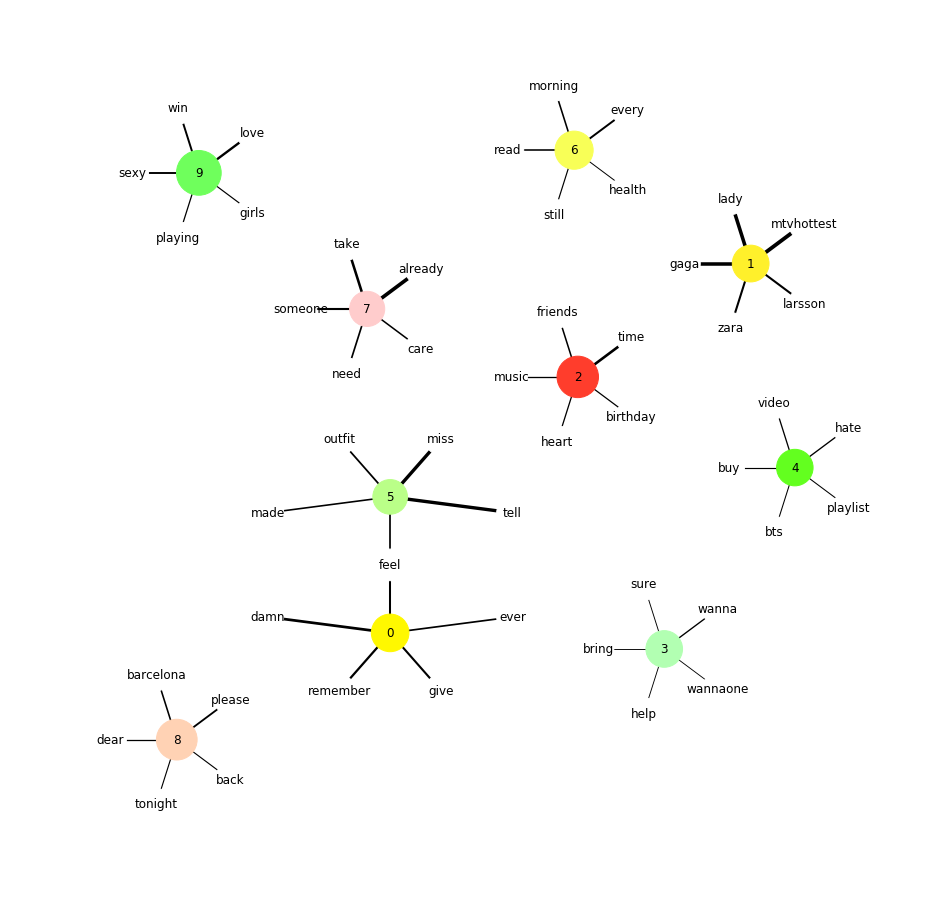

In [8]:
# Visualize topics and sentiment 

# Size: percentage of tweets in that topic 
# -> (positive + negative + neutral + irrelevant) / number of tweets
# Scaled to (0,2000)
sizes = [ (topics_sentiments[index]["positive"] 
         + topics_sentiments[index]["negative"] 
         + topics_sentiments[index]["neutral"]
         + topics_sentiments[index]["irrelevant"])
         / len(tweets)
         for index in topics_sentiments]

sizes = [size/max(sizes)*2000 for size in sizes]

# color: polarity 
# -> positive / (negative+positive)
# Scaled to (0,120) (hue from red to green on a HSV scale)
hues = [  topics_sentiments[index]["positive"] 
        /(topics_sentiments[index]["negative"] 
        + topics_sentiments[index]["positive"])
        * 120
        for index in topics_sentiments]

# Expanded to [1,120] to show the effect better
hues = [(hue-min(hues)) for hue in hues]
hues = [hue/max(hues)*120 for hue in hues]

# subjectivity: transparency
# --> (positive+negative) / (negative+positive+neutral)
# Scaled to (0,1) (saturation from white to full color on a HSV scale)
saturations = [(  topics_sentiments[index]["positive"] 
                + topics_sentiments[index]["negative"])
                /(topics_sentiments[index]["positive"] 
                + topics_sentiments[index]["negative"]
                + topics_sentiments[index]["neutral"])
                for index in topics_sentiments]

# Expanded to [.2,1] to show the effect better
saturations = [(saturation-min(saturations)) for saturation in saturations]
saturations = [(saturation)/max(saturations)*0.8+0.2 for saturation in saturations]

import colorsys    
colors = [colorsys.hsv_to_rgb(hues[index] / 360,saturations[index],1) for index in range(len(topics_sentiments))]
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for (r,g,b) in colors]
graph = nx.Graph()

for i in range(len(topics_sentiments)): 
    graph.add_node(i,color=colors[i],size=sizes[i])
    for (term_id, term_probability) in lda.get_topic_terms(topicid=i, topn=5):
        graph.add_edge(i,dictionary[term_id], weight=term_probability*100)    

plt.figure(figsize=(16,16))

pos = graphviz_layout(graph, prog="twopi", root='1')
nodes = graph.nodes()

# nodes
nodes = graph.nodes(data=True)
node_color = [node[1]['color'] if 'color' in node[1] else "#FFFFFF" for node in nodes]
node_size = [node[1]['size'] if 'size' in node[1] else 1000 for node in nodes]
nx.draw_networkx_nodes(graph,pos, node_color=node_color,node_size=node_size)

# edges
edges = graph.edges()
weights = [graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(graph,pos,edgelist=edges,width=weights)

# labels
nx.draw_networkx_labels(graph,pos,font_size=12,font_family='sans-serif')

plt.axis('off')
plt.savefig('combined_network_graph.pdf', format="pdf",bbox_inches='tight')
plt.show()